In [1]:
import numpy as np
import pandas as pd
import csv
from scipy.constants import mu_0, epsilon_0
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import ipywidgets
import discretize
import  os
import json
from PIL import Image
import seaborn as sns
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import ipywidgets as widgets
eps = np.finfo(float).eps

In [2]:
import empymod
from masa_utils import PsuedoLog
from masa_utils import Pelton_res_f
from masa_utils import InducedPolarizationSimulation 
from masa_utils import Optimization 
from masa_utils import empymod_IP_simulation
from masa_utils import TEM_Signal_Process


Simulatin and synthetic study on deep sea hydrothermal deposits explortaion using WISTEM (K. Nakayama and A. Saito, 2016) (K.Nakayama M. Motoori and A. Saito,2019). On-Time: 200msec ramp time: 200usec Transmitter Loop: 3.5m Square Loop Receiver Loop: Coincident-type Number of Turn: 5 3.5m rectangular loop has equivalent area for 2.0m circular loop.

In [3]:
base_freq=1.25
on_time=0.2
rmp_time=200e-6
rec_time=3e-2
smp_freq=50e3 #200e3  

In [4]:
tx_side = 3.5
tx_radius = (tx_side)/(np.sqrt(np.pi))
tx_circumeference = 2*np.pi*tx_radius
tx_surface = np.pi*tx_radius**2
n_turns = 5
tx_depth = 0
print(f"Transmitter radius: {tx_radius}")

Transmitter radius: 1.9746635424171473


In [5]:
tstrt, tend = 1e-4, 3e-2
logstep = 1/15
WISTEM_SP_sim = TEM_Signal_Process(
    rmp_time=rmp_time, 
    rec_time=tend, 
    smp_freq=smp_freq
)


In [6]:
times_sim = WISTEM_SP_sim.times_rec
times_clc = WISTEM_SP_sim.times_rec
ntimes = len(times_clc)
print(ntimes)
print(times_clc[:3], times_clc[-3:])
WISTEM_SP_sim.get_window_log(tstart=tstrt,logstep=logstep)
windows_strt = WISTEM_SP_sim.windows_strt
windows_cen = WISTEM_SP_sim.windows_cen
windows_end = WISTEM_SP_sim.windows_end
print(windows_cen-rmp_time)

1500
[2.e-05 4.e-05 6.e-05] [0.02996 0.02998 0.03   ]
[0.0001     0.00011659 0.00013594 0.00015849 0.00018478 0.00021544
 0.00025119 0.00029286 0.00034145 0.00039811 0.00046416 0.00054117
 0.00063096 0.00073564 0.0008577  0.001      0.00116591 0.00135936
 0.00158489 0.00184785 0.00215443 0.00251189 0.00292864 0.00341455
 0.00398107 0.00464159 0.0054117  0.00630957 0.00735642 0.00857696
 0.01       0.01165914 0.01359356 0.01584893 0.0184785  0.02154435
 0.02511886 0.02928645]


In [7]:
nlayer =1

rho0_target = 0.3
eta_target, eta_ref = 0.4, 0.01
eta_sea , eta_base = 0.,0.
c_target = 0.4 
thick_target = 10.
tau_target = 3e-2

res_sea = 0.3
res_base = 1.0
tau_sea, tau_base = 3e-2, 3e-2
c_sea, c_base = 0.4,0.4
rho0_refs = np.r_[0.3, 0.3 , 0.3]
tau_refs = np.r_[3e-2, 3e-2, 3e-2]
c_refs = np.r_[0.4, 0.4, 0.4]

depth = np.r_[0, thick_target]
print(f"depth {depth}")
tx_height = 0.3 #csx
print(tx_height)

depth [ 0. 10.]
0.3


In [8]:
nmodel=3
m_trues = []
m_refs = []
m_true  = np.r_[np.log(rho0_target), eta_target, np.log(tau_target), c_target]
for i in range(nmodel):
    m_trues.append(m_true)
    m_ref = np.r_[np.log(rho0_refs[i]), eta_ref, np.log(tau_refs[i]), c_refs[i]]
    m_refs.append(m_ref)
    print(m_ref)   


[-1.2039728  0.01      -3.5065579  0.4      ]
[-1.2039728  0.01      -3.5065579  0.4      ]
[-1.2039728  0.01      -3.5065579  0.4      ]


In [9]:
WISTEM_SP_sim.get_window_log(tstart=tstrt,logstep=logstep)
filt_linrmp = WISTEM_SP_sim.filter_linear_rmp()

Window_mat = WISTEM_SP_sim.get_window_matrix(times_sim)
print(Window_mat.shape)

(38, 1500)


In [10]:
recx, recy = 0 , 0
recBdple = [recx, recy, tx_depth ,0,90]
# recx, recy, recw = rec_area(3, tx_side)
# recBdple = [recx, recy, tx_depth ,0,90]

In [11]:
# emoymod model to simulate WISTEM setting
# Note that it simulate only dBdt field at center of the transmitter loop
# User should multiply by area of the loop to get EMF(V/A)
empymod_model_sim = {
    # simulate each bipole of four side of the transmitter loop
    'src': [ tx_side/2, tx_side/2,  # x1,x2
                     0, tx_side/2,  # y1,y2
             tx_depth, tx_depth], # z1,z2
    # receiver at the center of the transmitter loop
    'rec': recBdple, # [recx, recy, tx_depth ,0,90], # dBzdt at x,y,z,azimuth,dip
    'depth': depth,
#    'res' : res,
#    'freqtime': times_sim,
    'signal': None, # 0: impulse or dBdt, 1: Stepoff or B field
    'msrc' : False, # Electric source
    'mrec' : True, # Magnetic receiver
    'strength': 8.*n_turns* tx_surface * mu_0,  
    'srcpts' : 3,  # Three works for the momtent, maybe worth seeking other number
    'verb': 0, # put 4 for more information
     # Setting xdirect=True can help, as direct field is then computed analytically in f-domain
    'xdirect': True,
}

In [12]:
sim_obs=empymod_IP_simulation(ip_model='pelton',
    model_base=empymod_model_sim, nlayer=nlayer,tx_height=tx_height,
    times=times_sim, smp_freq=smp_freq
    )
sim_obs.deepsea_signle_layer(
    res_sea=res_sea, res_base=res_base,
    eta_sea=eta_sea, eta_base=eta_base,
    tau_sea=tau_sea, tau_base=tau_base, 
    c_sea=c_sea, c_base=c_base
    )


In [13]:
print(sim_obs.m_fix)
print(sim_obs.model_base)

[-1.2039728  0.         0.         0.         0.         0.
 -3.5065579  0.        -3.5065579  0.4        0.         0.4      ]
{'src': [1.75, 1.75, 0, 1.75, 0, 0], 'rec': [0, 0, 0, 0, 90], 'depth': array([ 0., 10.]), 'signal': None, 'msrc': False, 'mrec': True, 'strength': np.float64(0.0006157521600223001), 'srcpts': 3, 'verb': 0, 'xdirect': True}


In [14]:
mvec_obs = m_trues[0]
sim_obs.cut_off = None
dpred_step= sim_obs.dpred(mvec_obs)
sim_obs.cut_off = smp_freq/2.0
print(f"cutoff frequency: {sim_obs.cut_off}")
dpred_LPF = sim_obs.dpred(mvec_obs)
sim_obs.filt_curr = filt_linrmp
dpred_rmp = sim_obs.dpred(mvec_obs)
sim_obs.window_mat=Window_mat
dpred_window = sim_obs.dpred(mvec_obs)

cutoff frequency: 25000.0


In [15]:
PL_decay = PsuedoLog(
    logmin=1e-8,
    linScale=0.5,
    logminx=1e-4,
    linScalex=0.5
    )
PL_jac = PsuedoLog(
    logmin=1e-8,
    linScale=0.5,
    logminx=1e-4,
    linScalex=0.2
    )

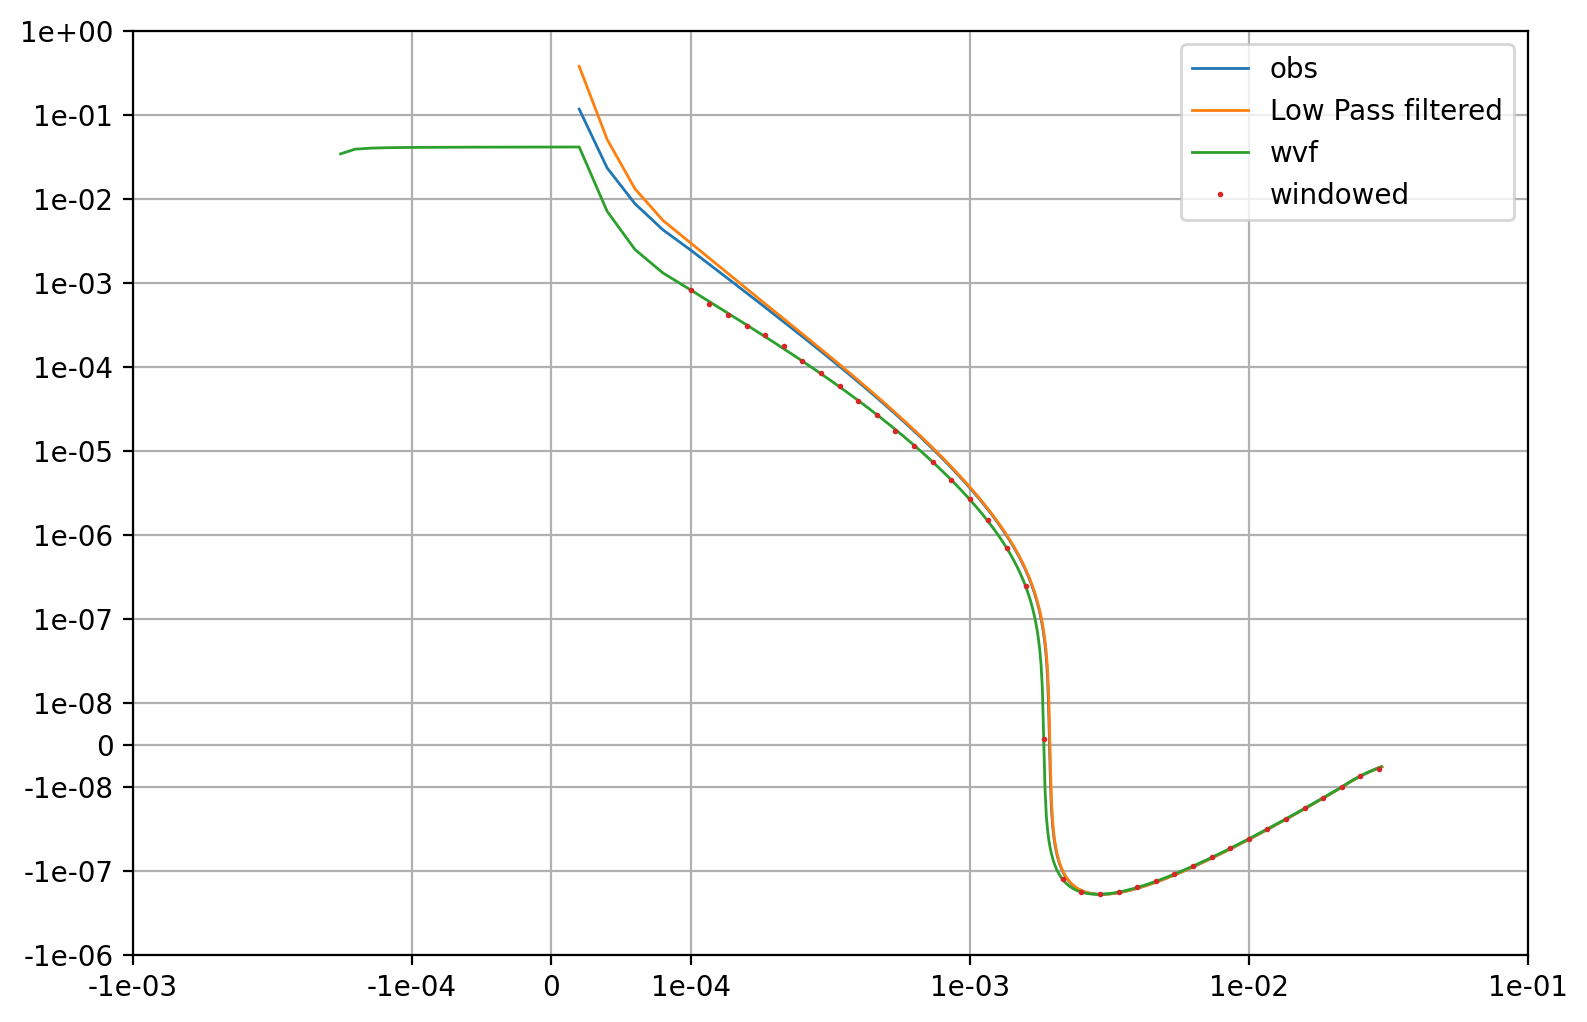

In [16]:

fig, ax= plt.subplots(1,1, figsize=(9,6), dpi=200)

ax= PL_decay.plpl_plot(
     x=times_clc,y=dpred_step , linestyle="-",label="obs", color="C0",ax=ax)
ax= PL_decay.plpl_plot(
     x=times_clc,y=dpred_LPF , linestyle="-",label="Low Pass filtered", color="C1",ax=ax)
ax= PL_decay.plpl_plot(
     x=times_clc-rmp_time,y=dpred_rmp , linestyle="-",label="wvf", color="C2",ax=ax)
ax= PL_decay.plpl_plot(
     x= windows_cen-rmp_time,y=dpred_window , marker="o",linestyle="",label="windowed", color="C3",ax=ax)
ax= PL_decay.pl_axes(ax)
ax= PL_decay.pl_axes_x(ax)
#for ax in ax:
ax.grid()
ax.legend()


In [17]:
relative_error=0.05
data_noise_floor = 0.1e-7

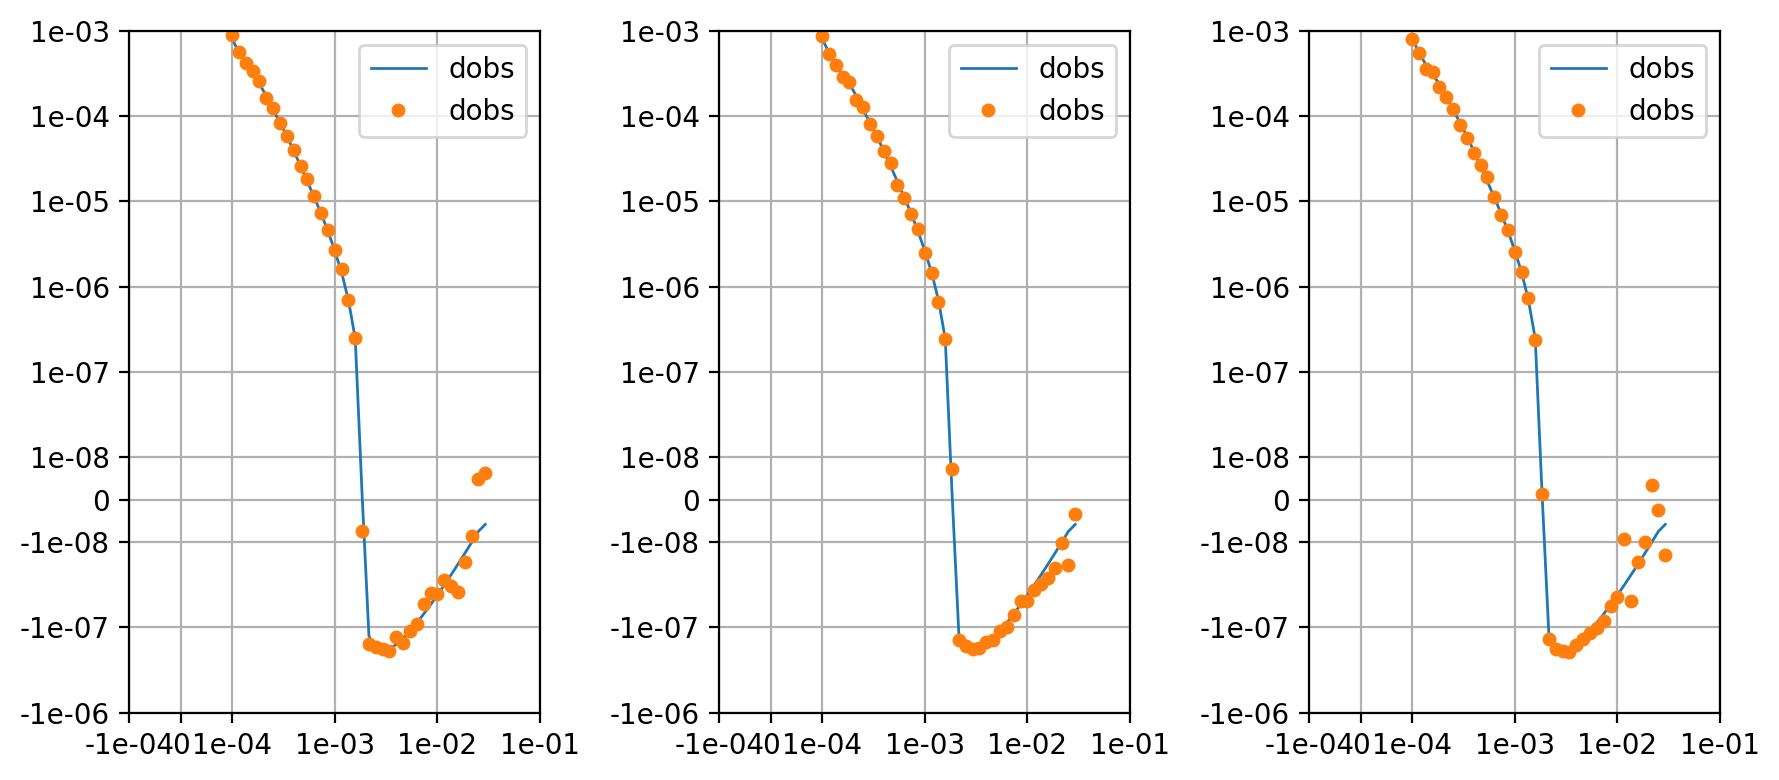

In [18]:
fig, ax= plt.subplots(1,3, figsize=(9,4), dpi=200)
dobs_cmb =[]
ax= ax.flatten()
 # For reproducibility

for i in range(nmodel):
   np.random.seed(i) # np.random.seed(0)  --- IGNORE --- 
   # Calculate noise floor and relative erro at each window
   mvec_obs = m_trues[i]
   dobs_clean=sim_obs.dpred(mvec_obs)
   noise_floor = data_noise_floor
   noise_relative = relative_error * np.abs(dobs_clean)

   # Combine the two sources of noise
   total_noise = np.sqrt(noise_floor**2 + noise_relative**2)

   # Add the combined noise to the clean data
   dobs = dobs_clean +  np.random.randn(len(dobs_clean)) * total_noise

   dobs_cmb.append(dobs)
   ax[i]=PL_decay.plpl_plot(x= windows_cen-rmp_time,y=dobs_clean, 
      label="dobs", color="C0", linestyle="-",ax=ax[i]
   )
   ax[i]=PL_decay.plpl_plot(x= windows_cen-rmp_time,y=dobs, 
      label="dobs", color="C1", marker="o",markersize=4,linestyle="",ax=ax[i]
   )
   ax[i]= PL_decay.pl_axes(ax[i])
   ax[i]= PL_decay.pl_axes_x(ax[i])
#for ax in ax:
   ax[i].grid()
   ax[i].legend()
plt.tight_layout()   

# Invert with Pelton model

In [19]:
niter = 50
stol=1e-6
coolingFactor = 2.0
coolingRate = 2
mu=1e-3
beta0_ratio = 1

In [20]:
models_rec = []
dpreds = []
error_prgs = []
model_prgs = []
dinit_refs = []
data_prgs =[]
for i in range(nmodel):
    m_ref = m_refs[i]
    dobs = dobs_cmb[i]
    opt_pelton = Optimization(sim=sim_obs, dobs=dobs, alphas=1.0)
    opt_pelton.get_Wd(ratio=relative_error, plateau=noise_floor)
    Wd=opt_pelton.Wd
    smallness = np.ones(4)
    opt_pelton.get_Ws(smallness=smallness)
    beta0 = opt_pelton.BetaEstimate_byEig(
        mvec=m_ref, update_Wsen=True, beta0_ratio=beta0_ratio)
    print(beta0)
    mpred = opt_pelton.GaussNewton(
    mvec_init=m_ref,niter=niter,beta0=beta0, update_Wsen=True,
    stol=stol,mu=mu,coolingRate=coolingRate, coolingFactor=coolingFactor
    )
    
    dinit_refs.append(opt_pelton.dpred(m_ref))
    models_rec.append(mpred)
    dpreds.append(opt_pelton.dpred(mpred))
    error_prgs.append(opt_pelton.error_prg)
    model_prgs.append(opt_pelton.mvec_prg)
    data_prgs.append(opt_pelton.data_prg)


1720151699.0012732
  1, beta:1.7e+09, step:1.0e+00, g:3.0e+04, phid:1.3e+04, phim:2.9e-10, f:1.3e+04 
  2, beta:1.7e+09, step:1.0e+00, g:5.8e+01, phid:1.3e+04, phim:2.9e-10, f:1.3e+04 
  3, beta:8.6e+08, step:1.0e+00, g:1.5e+04, phid:1.3e+04, phim:1.2e-09, f:1.3e+04 
  4, beta:8.6e+08, step:1.0e+00, g:5.8e+01, phid:1.3e+04, phim:1.2e-09, f:1.3e+04 
  5, beta:4.3e+08, step:1.0e+00, g:1.5e+04, phid:1.3e+04, phim:4.6e-09, f:1.3e+04 
  6, beta:4.3e+08, step:1.0e+00, g:1.2e+02, phid:1.3e+04, phim:4.7e-09, f:1.3e+04 
  7, beta:2.2e+08, step:1.0e+00, g:1.5e+04, phid:1.3e+04, phim:1.9e-08, f:1.3e+04 
  8, beta:2.2e+08, step:1.0e+00, g:2.3e+02, phid:1.3e+04, phim:1.9e-08, f:1.3e+04 
  9, beta:1.1e+08, step:1.0e+00, g:1.5e+04, phid:1.3e+04, phim:7.6e-08, f:1.3e+04 
 10, beta:1.1e+08, step:1.0e+00, g:4.6e+02, phid:1.3e+04, phim:7.7e-08, f:1.3e+04 
 11, beta:5.4e+07, step:1.0e+00, g:1.5e+04, phid:1.3e+04, phim:3.1e-07, f:1.3e+04 
 12, beta:5.4e+07, step:1.0e+00, g:9.2e+02, phid:1.3e+04, phim:3.3e-

In [21]:
phid_star=len(windows_cen)
models_rec_phid = []
dpreds_phid = []
phid_star_ratio =1.0
phid_itrs = []
for i in range(nmodel):
    model_prg= np.array(model_prgs[i])
    data_prg = np.array(data_prgs[i])
    error_prg = error_prgs[i]
    phid_prg = np.array(error_prg)[:,1]
    ind = phid_prg < phid_star*phid_star_ratio
    if np.sum(ind) == 0:
        ind = phid_prg == np.min(phid_prg)
    phid_itr = np.where(ind)[0][0]
    models_rec_phid.append(model_prg[ind][0])
    dpreds_phid.append(data_prg[ind][0])
    phid_itrs.append(phid_itr)


In [22]:
print( "Parameter:     res0,   chg,       tau,     c")

for i in range(nmodel):
    np_mvec_ref = m_refs[i]
    np_mvec_est = models_rec[i]
    m_est_phid = models_rec_phid[i]
    mvec_obs = m_trues[i]
    print(f"ref{i+1}     & {np.exp(np_mvec_ref[0]):.2e} & {np_mvec_ref[1]:.3f} & {np.exp(np_mvec_ref[2]):.2e} & {np_mvec_ref[3]:.3f}")
    # print(f"est{i+1}     & {np.exp(np_mvec_est[0]):.2e} & { np_mvec_est[1]:.3f} & { np.exp(np_mvec_est[2]):.2e} & { np_mvec_est[3]:.3f}")
    print(f"est_phid{i+1}& {np.exp(m_est_phid[0]):.2e} & { m_est_phid[1]:.3f} & { np.exp(m_est_phid[2]):.2e} & { m_est_phid[3]:.3f}")
    print(f"true     & {np.exp(mvec_obs[0]):.2e} & {mvec_obs[1]:.3f} & {np.exp(mvec_obs[2]):.2e} & {mvec_obs[3]:.3f}")

Parameter:     res0,   chg,       tau,     c
ref1     & 3.00e-01 & 0.010 & 3.00e-02 & 0.400
est_phid1& 2.52e-01 & 0.186 & 2.94e-03 & 0.683
true     & 3.00e-01 & 0.400 & 3.00e-02 & 0.400
ref2     & 3.00e-01 & 0.010 & 3.00e-02 & 0.400
est_phid2& 2.68e-01 & 0.218 & 3.97e-03 & 0.628
true     & 3.00e-01 & 0.400 & 3.00e-02 & 0.400
ref3     & 3.00e-01 & 0.010 & 3.00e-02 & 0.400
est_phid3& 2.76e-01 & 0.200 & 3.67e-03 & 0.694
true     & 3.00e-01 & 0.400 & 3.00e-02 & 0.400


In [23]:
S_pelton= []
for i in range(nmodel):
    # jacobian = sim_obs.J(models_rec[i])
    jacobian = sim_obs.J(models_rec_phid[i])
    U, S, V = np.linalg.svd(Wd@jacobian, full_matrices=False)
    s_norm = S/S.max()
    S_pelton.append(s_norm)
print(S_pelton)

[array([1.        , 0.09553097, 0.02914656, 0.00675367]), array([1.        , 0.10638566, 0.03130589, 0.0046916 ]), array([1.        , 0.10984699, 0.03349609, 0.00604308])]


findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


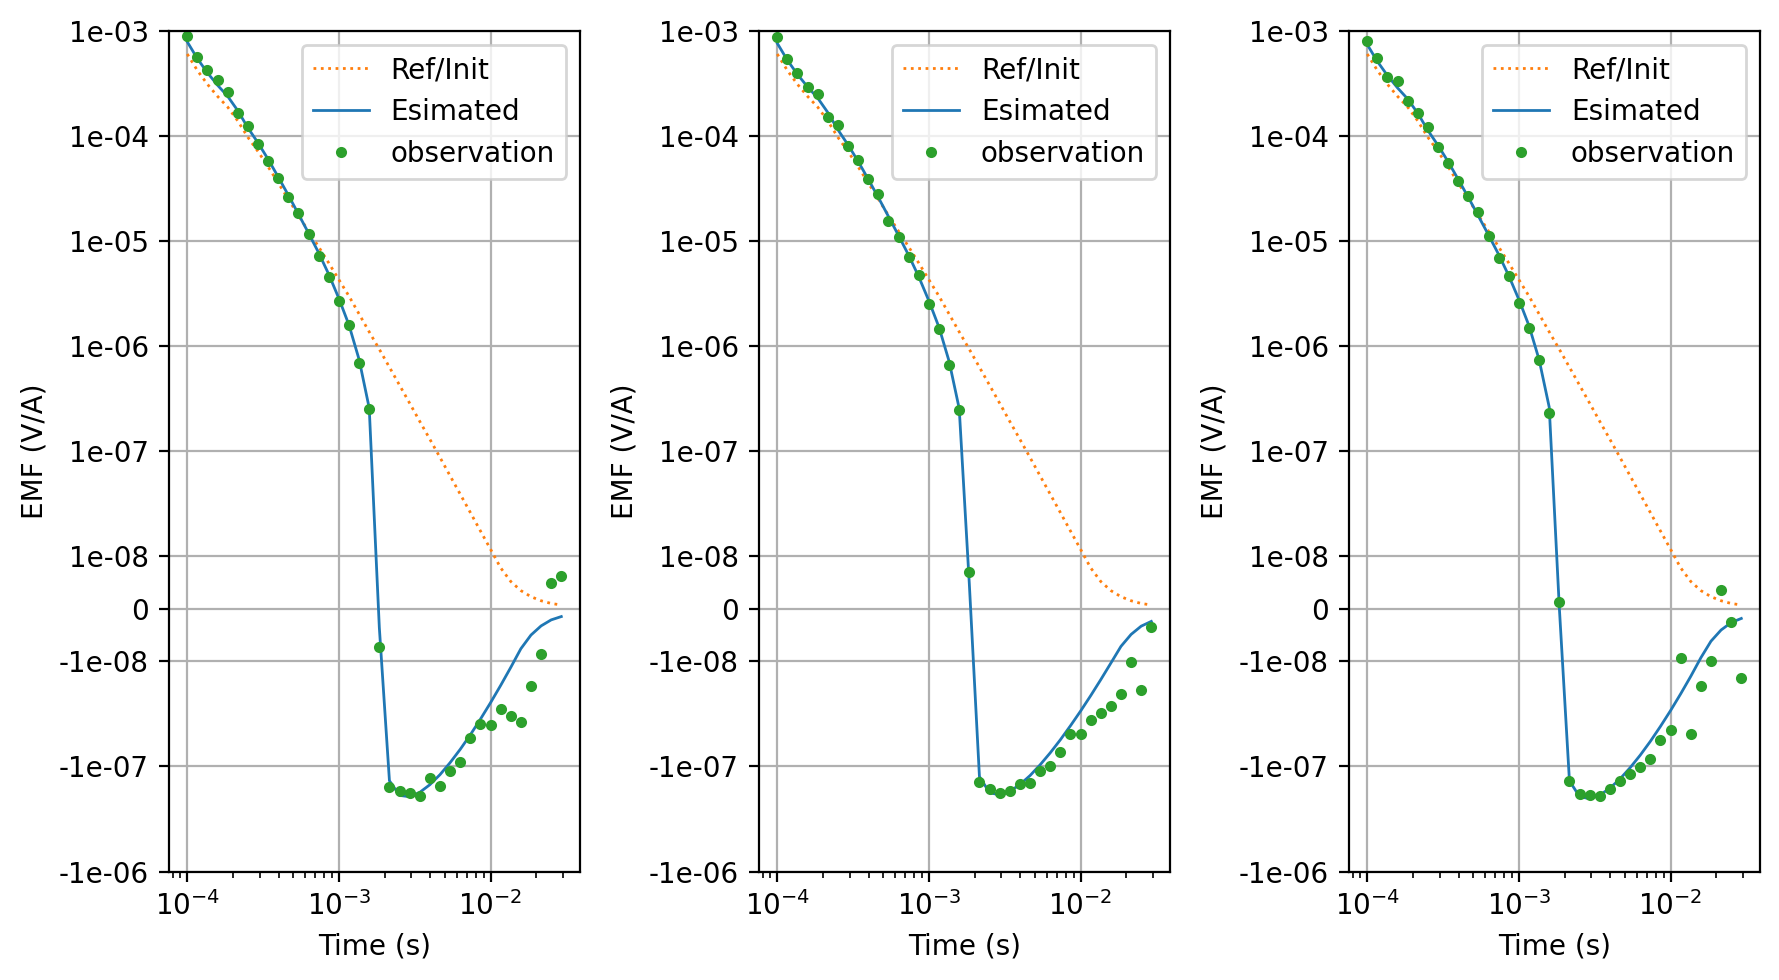

In [24]:
fig, ax= plt.subplots(1,3, figsize=(9,5), dpi=200)
ax= ax.flatten()
for i in range(nmodel):
    dobs= dobs_cmb[i]   
    dinit_ref = dinit_refs[i]

    ax[i]=PL_decay.semiply(
        windows_cen-rmp_time, dinit_ref, ax=ax[i],
        color=f"C1",linestyle=":", label=f"Ref/Init"
        )

    ax[i]=PL_decay.semiply(
        windows_cen-rmp_time, dpreds_phid[i], ax=ax[i],
        color=f"C0",linestyle="-", label=f"Esimated"
        )
    ax[i]=PL_decay.semiply(
        windows_cen-rmp_time, dobs, ax=ax[i], marker="o",markersize=3.0,
        color=f"C2",linestyle="", label="observation"
        )
    ax[i] = PL_decay.pl_axes(ax[i])
    ax[i].grid()
    ax[i].legend()
    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("EMF (V/A)")
plt.tight_layout()

# Get sip of the target

In [25]:
freq = 10.**np.arange(-1,5.1,0.1)
nfreq = len(freq)
IP_model = Pelton_res_f(freq=freq)
sim = InducedPolarizationSimulation(ip_model=IP_model, mode='sip')


In [26]:
relative_error = 0.05
noise_floor_ratio = 1e-3
niter = 100
stol=1e-6
coolingFactor = 2 
coolingRate = 2
mu=1e-3
beta0_ratio = 1.0

In [27]:
sip_true =[]
sip_dpreds = []
model_recs = []
error_prgs = []
model_prgs = []
data_prgs =[]
betas_prgs = []
for i in range(nmodel):

    mvec_obs = m_trues[i]
    dobs = sim.dpred(m=mvec_obs)
    sip_true.append(dobs)
    f_abs = abs(IP_model.f(mvec_obs))
    noise_floor= f_abs.max()*noise_floor_ratio
    sip_dpreds.append(sim.dpred(models_rec_phid[i]))
    


In [34]:
def plot_sip(freq, dpreds, ax=None, **kwargs):
    if ax is None: 
        fig, ax = plt.subplots(2, 1, figsize=(5,3))
    nfreq = len(freq)

    default_kwargs = {
        "linestyle": "-",
        "color": "C0",
        "linewidth": 1.0,
        "marker": None,
        "markersize": 1,
    }
    default_kwargs.update(kwargs)
    nfreq = len(dpreds)//2

    sip_real = dpreds[:nfreq]
    sip_imag = dpreds[nfreq:]
    sip_abs = np.abs(sip_real + 1j * sip_imag)
    sip_phs = np.angle(sip_real + 1j * sip_imag, deg=True)
    ax[0].semilogx(freq, sip_abs, **default_kwargs)
    ax[1].semilogx(freq, sip_phs, **default_kwargs)

    ax[0].set_ylabel(r'$|\rho^{\ast}|~(\Omega\cdot\mathrm{m})$')

    ax[1].set_ylabel(r'$\phi~(^\circ)~(\mathrm{deg}) $')


    for a in ax:
        a.set_xlabel("Frequency [Hz]")

    return ax

In [35]:
def plot_data(iteration, ax=None):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5,3))
       
    ax=PL_decay.semiply(windows_cen-rmp_time, data_init, ax=ax,
                       color="C1",label="Ref"
                       )
    ax=PL_decay.semiply(windows_cen-rmp_time, dpreds, ax=ax
                        ,color="C0",linestyle="-",
                        label=f"Est" #, iter={iteration}"
                        )
    ax=PL_decay.semiply(windows_cen-rmp_time, dobs, ax=ax, marker="o",markersize=3.0,
                       color="C2",linestyle="", label="Obs"
                       )
    ax = PL_decay.pl_axes(ax)
    # ax.grid()
    # ax.legend()
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("EMF (V/A)")
    ax.set_title(f""" Data plot
Relative error {relative_error*100:.1f} %, noise floor {data_noise_floor:.1e} V/A""")
    return ax

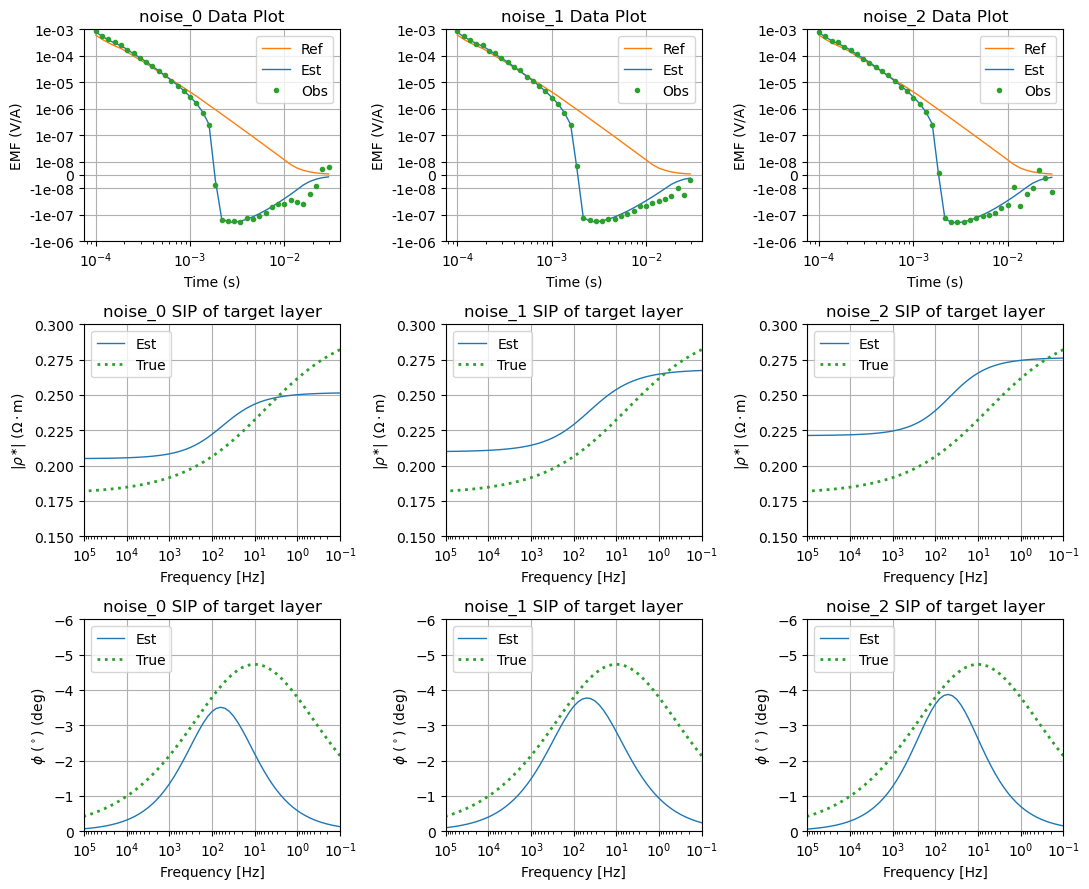

In [36]:
fig, ax = plt.subplots(3, 3, figsize=(11,9))
title_heads = ["noise_0", "noise_1", "noise_2"] #  ["ref_0", "ref_1", "ref_2"] 
ax_ranges = []
ax_ranges.append([ax[0, 0], ax[1, 0], ax[2, 0]])
ax_ranges.append([ax[0, 1], ax[1, 1], ax[2, 1]])
ax_ranges.append([ax[0, 2], ax[1, 2], ax[2, 2]])
for i in range(nmodel):
    title_head = title_heads[i]
    phid_itr = phid_itrs[i]
    data_init = dinit_refs[i]
    dpreds = dpreds_phid[i]
    dobs= dobs_cmb[i]
    ax_range = ax_ranges[i]
    axdata = ax_range[0]
    axdata = plot_data(iteration=phid_itr, ax=axdata)
    axsip = [ax_range[1], ax_range[2]]
    axsip = plot_sip(freq, sip_dpreds[i], 
             ax=axsip, color="C0", label=f"Est", linestyle="-"
             )
    # axsip = plot_sip(freq, sip_true_dpred[i], 
    #          ax=axsip, color="C1", label=f"Estimated by sip", linestyle="-"
    #          )
    axsip  = plot_sip(freq=freq,
              dpreds=sip_true[i],ax=axsip, color="C2", label=f"True", linestyle=":",
              linewidth=2.0)
    axsip[0].set_ylim(bottom=0.15, top=0.30)
    axsip[1].set_ylim(top=-6, bottom=0)
    for a in axsip:
        a.set_xlim(left=1e5, right=0.1)

    for a in ax_range:
        a.legend()
        a.grid()

    ax_range[0].set_title(f"{title_head} Data Plot")
    ax_range[1].set_title(f"{title_head} SIP of target layer")
    ax_range[2].set_title(f"{title_head} SIP of target layer")

plt.tight_layout()
plt.savefig('33_Pelton_data.jpg', dpi=300)

# Plot Inversion result

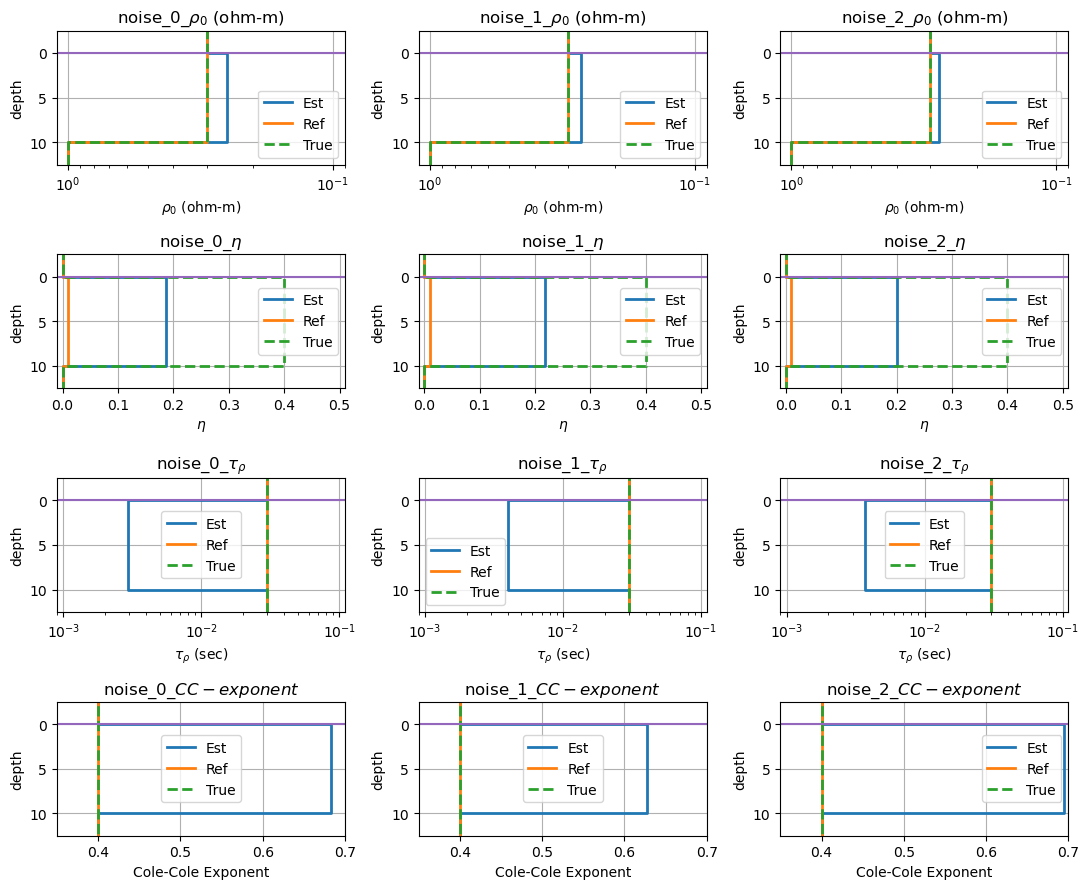

In [31]:
fig, ax = plt.subplots(4, 3, figsize=(11,9))

ax_ranges = []
ax_ranges.append([ax[0, 0], ax[1, 0], ax[2, 0], ax[3,0]])
ax_ranges.append([ax[0, 1], ax[1, 1], ax[2, 1], ax[3,1]])
ax_ranges.append([ax[0, 2], ax[1, 2], ax[2, 2], ax[3,2]])
for i in range(nmodel):
    title_head = title_heads[i]
    m_tem = models_rec_phid[i]
    m_ref = m_refs[i]
    # m_sip = sip_true_inv[i] 
    m_true = m_trues[i]
    axtmp = ax_ranges[i]
    axtmp = sim_obs.plot_IP_par(mvec=m_tem, 
        label="Est", color=f"C0", linestyle="-", 
        ax=axtmp, linewidth=2.0)
    # rho0,eta = sim.ip_model.get_rho_eta(models_rec_phid[i])
    axtmp = sim_obs.plot_IP_par(mvec=m_ref, 
            label="Ref", color=f"C1", linestyle="-",
            ax=axtmp, linewidth=2.0)

    # label = fr"est_$\rho_0$: {rho0: .1e}, $\eta$: {eta: .2f}"

    axtmp = sim_obs.plot_IP_par(mvec=m_true, 
            label="True", color=f"C2", linestyle="--",
            ax=axtmp, linewidth=2.0)
    # rho0,eta = sim.ip_model.get_rho_eta(sip_true_inv[i])
    # label = fr"tru_$\rho_0$: {rho0: .1e}, $\eta$: {eta: .2f}"

    axtmp[0].set_xlim([1.1,0.09])
    axtmp[1].set_xlim([-0.01,0.51])
    axtmp[2].set_xlim([0.9e-3,1.1e-1])
    axtmp[3].set_xlim([0.35,0.7])

    for j , a in enumerate(axtmp):  # Iterate over rows
        a.grid()
        a.legend()
        a.axhline(empymod_model_sim["src"][4], color=f"C4", linestyle="-", label="Src+Rec")
        a.set_ylim([12.5, -2.5])
        a.set_ylabel('depth')
        if j== 0 or j==2:
            a.set_xscale("log")
        else:
            a.set_xscale("linear")
    axtmp[0].set_title(fr"{title_head}_$\rho_0$ (ohm-m)")
    axtmp[1].set_title(fr"{title_head}_$\eta$")
    axtmp[2].set_title(fr"{title_head}_$\tau_\rho$")
    axtmp[3].set_title(fr"{title_head}_$CC-exponent$")

plt.tight_layout()
plt.savefig('33_Pelton_recovered.jpg', dpi=300)

In [32]:
def plot_each_data(data, ax=None, **kwargs):
    default_kwargs = {
        "linestyle": "-",
        "color": "C0",
        "linewidth": 1.0,
        "marker": None,
        "markersize": 1,
    }
    default_kwargs.update(kwargs)
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5,3))
       
    ax=PL_decay.semiply(windows_cen-rmp_time, data, ax=ax,
                       **default_kwargs
                       )
    ax = PL_decay.pl_axes(ax)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("EMF (V/A)")
    ax.set_title(f""" Data plot
Relative error {relative_error*100:.1f} %, noise floor {data_noise_floor:.1e} V/A""")
    return ax

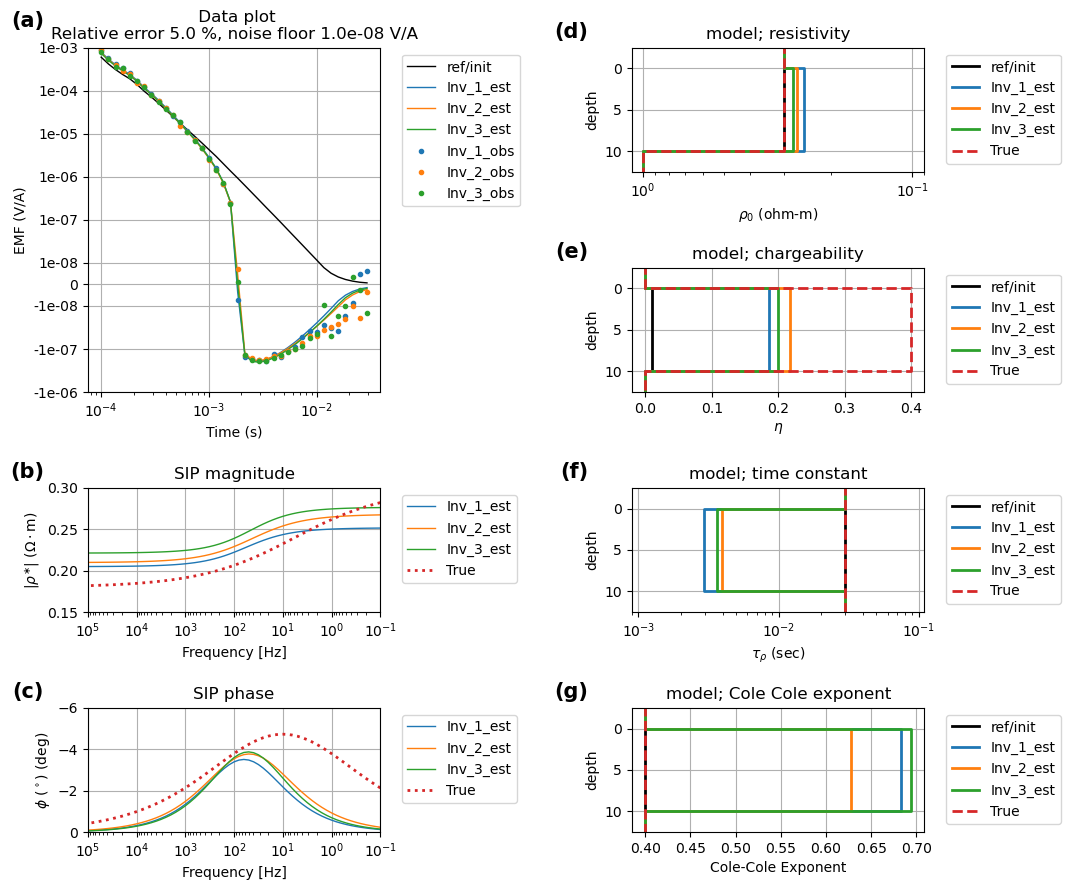

In [38]:

title_heads = ["Inv_1", "Inv_2", "Inv_3"] #  ["ref_0", "ref_1", "ref_2"] 

fig = plt.figure(figsize=(11, 9))
gs = gridspec.GridSpec(4, 2)  
ax = [None] * 7

# Subplots
ax[0] = fig.add_subplot(gs[:2, 0])
ax[1] = fig.add_subplot(gs[2, 0])
ax[2] = fig.add_subplot(gs[3, 0])
ax[3] = fig.add_subplot(gs[0, 1])
ax[4] = fig.add_subplot(gs[1, 1])
ax[5] = fig.add_subplot(gs[2, 1])
ax[6] = fig.add_subplot(gs[3, 1])

axdata = ax[0]
axsip = [ax[1], ax[2]]
axmodel = [ax[3], ax[4], ax[5], ax[6]]

data_init = dinit_refs[0]

axdata = plot_each_data(data=data_init,
            label=f"ref/init",color=f"k", 
            ax=axdata)
m_ref = m_refs[0]
axmodel= sim_obs.plot_IP_par(mvec=m_ref, 
    label="ref/init", color="k", linestyle="-", 
    ax=axmodel, linewidth=2.0)

for i in range(nmodel):
    title_head = title_heads[i]
    dpreds = dpreds_phid[i]
    m_tem = models_rec_phid[i]
    m_true = m_trues[i]
    # ax_range = ax_ranges[i]
    axdata = plot_each_data(data=dpreds,
             label=f"{title_head}_est",color=f"C{i}", 
             ax=axdata)
    axsip = plot_sip(freq, sip_dpreds[i], 
             ax=axsip, color=f"C{i}", label=f"{title_head}_est",
             )
    axmodel= sim_obs.plot_IP_par(mvec=m_tem, 
        label=f"{title_head}_est", color=f"C{i}", linestyle="-", 
        ax=axmodel, linewidth=2.0)

axmodel = sim_obs.plot_IP_par(mvec=m_true, 
        label="True", color=f"C{nmodel}", linestyle="--",
        ax=axmodel, linewidth=2.0)


for i in range(nmodel):
    title_head = title_heads[i]
    dobs= dobs_cmb[i]
    # ax_range = ax_ranges[i]
    axdata = plot_each_data(data=dobs,
             label=f"{title_head}_obs",color=f"C{i}", 
             linestyle="", marker="o", markersize=3.0,
             ax=axdata)

axsip  = plot_sip(freq=freq,
            dpreds=sip_true[0],ax=axsip,
            color=f"C{nmodel}", label=f"True", linestyle=":",
            linewidth=2.0)
axsip[0].set_ylim(bottom=0.15, top=0.30)
axsip[1].set_ylim(top=-6, bottom=0)
for a in axsip:
    a.set_xlim(left=1e5, right=0.1)


axdata.set_title(f""" Data plot
Relative error {relative_error*100:.1f} %, noise floor {data_noise_floor:.1e} V/A""")
ax[1].set_title(f"SIP magnitude")
ax[2].set_title(f"SIP phase")

axmodel[0].set_xlim([1.1,0.09])
# axmodel[1].set_xlim([-0.01,0.51])
axmodel[2].set_xlim([0.9e-3,1.1e-1])
# axmodel[3].set_xlim([0.35,1.0])
axmodel[0].set_title("model; resistivity")
axmodel[1].set_title("model; chargeability")
axmodel[2].set_title("model; time constant")
axmodel[3].set_title("model; Cole Cole exponent")

for j , a in enumerate(axmodel):  # Iterate over rows
    # a.axhline(empymod_model_sim["src"][nmodel+1], color=f"C4", linestyle="-", label="Src+Rec")
    a.set_ylim([12.5, -2.5])
    a.set_ylabel('depth')
    if j== 0 or j==2:
        a.set_xscale("log")
    else:
        a.set_xscale("linear")

for a in ax:
    a.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # a.legend()
    a.grid()

# for a in axsip:
#     a.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

panel_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']

for label, axis in zip(panel_labels, ax):
    axis.text(
        -0.15, 1.05, label,
        transform=axis.transAxes,
        fontsize=15, fontweight='bold',
        va='bottom', ha='right'
    )

plt.tight_layout()
plt.savefig('33_Pelton.jpg', dpi=300)